# Preprocess testing
This file's aim is to test different preprocessing techniques on the dataset before implementing them in the real preprocess pipeline.

Content table:
1) [Dependencies](#dependencies)
2) [Open and read dataset](#open-and-read-dataset)
3) [Dataset analysis](#dataset-analysis)
4) [Sample generation](#samples-generation)
5) [Darken polygon's outside](#darken-polygons-outside)
6) [NDVI generation](#ndvi-generation)
7) [Greenery masking](#greenery-masking)
8) [Split among classes](#split-among-classes)
9) [Normalize image size](#normalize-image-size)
10) [Tests on final sample](#tests-on-final-sample)
11) [16bits samples: range-limiting](#16bits-samples-range-limiting)
12) [Overlapping samples](#overlapping-samples)
13) [WhiteboxTools testing](#whiteboxtools-testing)
14) [Repartition of samples when filtering the smallest ones out](#repartition-of-samples-when-filtering-the-smallest-ones-out)

### Dependencies

In [ ]:
# Lib Installation
#%pip install numpy pandas geopandas pyYAML matplotlib tqdm argparse rasterio pillow shapely

In [1]:
# Lib Import
import os
import sys
import shutil
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import yaml
from tqdm import tqdm
import argparse
import rasterio
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.plot import show
from tifffile import imread, imwrite
from skimage.transform import resize
from shapely import geometry
from PIL import Image, ImageSequence
from IPython.display import display

sys.path.insert(0,'D:\GitHubProjects\STDL_Classifier')
from src.preprocess_utils import range_limiting

### Open and read dataset

In [2]:
Image.MAX_IMAGE_PIXELS = 12058713924
filename_tlm = "../data/test/sample_tlm.tif"
filename_scratch = "../data/test/sample_scratch.tif"


In [4]:
# open tlm sample
raster_tlm = rasterio.open(filename_tlm)
raster_scratch = rasterio.open(filename_scratch)

In [5]:
# open scratch sample
arr_tlm = raster_tlm.read()
print(f"Min value = {np.min(arr_tlm)}")
print(f"Max value = {np.max(arr_tlm)}")

Min value = 0
Max value = 65533


### Dataset analysis

In [9]:
do_get_sample = False
if do_get_sample:
    df_raster_sample_r = pd.DataFrame(raster.read(1)).sample(frac=.0001,axis=1)
    df_raster_sample_r = df_raster_sample_r.sample(frac=0.001, axis=0)

    df_raster_sample_g = pd.DataFrame(raster.read(2)).sample(frac=.0001,axis=1)
    df_raster_sample_g = df_raster_sample_g.sample(frac=0.001, axis=0)

    df_raster_sample_b = pd.DataFrame(raster.read(3)).sample(frac=.0001,axis=1)
    df_raster_sample_b = df_raster_sample_b.sample(frac=0.001, axis=0)

    df_raster_sample_nir = pd.DataFrame(raster.read(4)).sample(frac=.0001,axis=1)
    df_raster_sample_nir = df_raster_sample_nir.sample(frac=0.001, axis=0)



#### Histogram

In [ ]:
# histogram of raw values
fig,axs = plt.subplots(1,4, figsize=(16,4))
fig.suptitle("Histogram TLM sample - Raw values")
for i in range(4):
    arr_raster = raster_tlm.read(i+1).flatten()
    axs[i].hist(arr_raster,log=True)
axs[0].set_title('R band')
axs[1].set_title('G band')
axs[2].set_title('B band')
axs[3].set_title('NIR band')
fig.tight_layout()
fig.savefig("../results/data_analysis/tlm_histogram_raw.png")
    


In [ ]:
# without zero values

fig,axs = plt.subplots(1,4, figsize=(16,4))
fig.suptitle("Histogram TLM sample - Without zero values")
for i in range(4):
    arr_raster = raster.read(i+1).flatten()
    arr_raster = arr_raster[arr_raster > 0]
    axs[i].hist(arr_raster,log=True)
axs[0].set_title('R band')
axs[1].set_title('G band')
axs[2].set_title('B band')
axs[3].set_title('NIR band')
fig.tight_layout()
fig.savefig("../results/data_analysis/tlm_histogram_nonzeros.png")

In [ ]:
# histogram of values clipped between 0 and 10000

fig,axs = plt.subplots(1,4, figsize=(16,4))
fig.suptitle("Histogram TLM sample - Values clipped at 10000")
for i in range(4):
    arr_raster = raster.read(i+1).flatten()
    arr_raster = arr_raster[arr_raster > 0]
    arr_raster = arr_raster[arr_raster < 10000]
    axs[i].hist(arr_raster,log=True)
axs[0].set_title('R band')
axs[1].set_title('G band')
axs[2].set_title('B band')
axs[3].set_title('NIR band')
fig.tight_layout()
fig.savefig("../results/data_analysis/tlm_histogram_10000.png")

In [ ]:
# histogram of values clipped between 0 and 1000

fig,axs = plt.subplots(1,4, figsize=(16,4))
fig.suptitle("Histogram TLM sample - Values clipped at 1000")
for i in range(4):
    arr_raster = raster.read(i+1).flatten()
    arr_raster = arr_raster[arr_raster > 0]
    arr_raster = arr_raster[arr_raster < 1000]
    axs[i].hist(arr_raster,log=True)
axs[0].set_title('R band')
axs[1].set_title('G band')
axs[2].set_title('B band')
axs[3].set_title('NIR band')
fig.tight_layout()
fig.savefig("../results/data_analysis/tlm_histogram_1000.png")

In [ ]:
# histogram of values clipped between 0 and 1000 with zeros

fig,axs = plt.subplots(1,4, figsize=(16,4))
fig.suptitle("Histogram TLM sample - Values clipped at 1000 with zeros")
for i in range(4):
    arr_raster = raster.read(i+1).flatten()
    arr_raster = arr_raster[arr_raster < 1000]
    axs[i].hist(arr_raster,log=True)
axs[0].set_title('R band')
axs[1].set_title('G band')
axs[2].set_title('B band')
axs[3].set_title('NIR band')
fig.tight_layout()
fig.savefig("../results/data_analysis/tlm_histogram_1000withZeros.png")

### Samples generation 

In [30]:
# data sources
roofs_dir = "../data/gt_tot.gpkg"

# open geopackage file
roofs = gpd.read_file(roofs_dir).to_crs(2056)
roofs_geom = []
roofs_bbox = []
roofs_bbox_geom = []

for roof in roofs.itertuples():
    roofs_geom.append(roof.geometry)
    roofs_bbox.append(roof.geometry.bounds)
    roofs_bbox_geom.append(geometry.box(*roof.geometry.bounds))


In [61]:
# data source
output_dir = "../results/images/tiles"
image_dir = "../data/test/img_source"

# get rasters
raster_list = []
image_list = []

# get list of image paths
for r, d, f in os.walk(image_dir):
    for file in f:
        if file.endswith('.tif'):
            file_src = r + '/' + file
            file_src = file_src.replace('\\','/')
            image_list.append(file_src)


# get list of rasters
for img in image_list:
    raster_list.append(rasterio.open(img))

# crop them to produce samples
for roof in tqdm(roofs.itertuples(index=True),total=len(roofs)):
    idx_roof = roof.Index

    for raster in raster_list:
        # catch the error when polygon doesn't match raster and just continue to next raster
        try:
            out_image, out_transform = mask(raster, [roofs_bbox_geom[idx_roof]], crop=True)
        except ValueError:
            continue
        else:
            out_meta = raster.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "width": out_image.shape[2],
                "height": out_image.shape[1],
                "transform": out_transform,
                "crs": rasterio.CRS.from_epsg(2056),
            })

            with rasterio.open(output_dir + '/' + "samp_" + str(int(roof.EGID))+ ".tif", "w", **out_meta) as dst:
                dst.write(out_image)



100%|██████████| 3784/3784 [01:25<00:00, 44.28it/s]


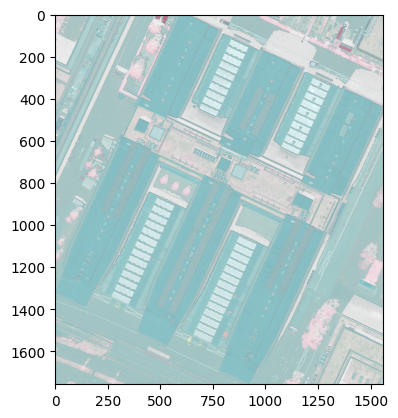

In [63]:
# show example before after
fig = plt.figure()
example_sample = plt.imread("../results/images/tiles/samp_11524802.tif")
plt.imshow(example_sample)
plt.show()
fig.savefig("../results/preprocess/original.png")
plt.close()

In [2]:
# test check if polygon entirely inside strip
# egid of a polygon overlapping two strips: 302014293
# egid of normal polygon: 302014346
# data source
output_dir = "../data/test/"
image_dir = "../data/test/img_source"
roofs_src = "../data/gt_tot.gpkg"

# get rasters
raster_list = []

for r, d, f in os.walk(image_dir):
    for file in f:
        if file.endswith('.tif'):
            file_src = r + '/' + file
            file_src = file_src.replace('\\','/')
            raster_list.append(rasterio.open(file_src))

# get polygons of roofs
roofs = gpd.read_file(roofs_src).to_crs(2056)
roof_of_interest = roofs[roofs.EGID.astype(int) == 302014293]
geom = roof_of_interest.geometry.values[0]
#geom = geometry.box(*roof_of_interest.geometry.bounds.values[0])
matching_rasters = []
for raster in raster_list:
    try:
        out_image, out_transform = mask(raster, [geom], crop=True)
    except ValueError:
        continue
    else:
        print(raster)
        matching_rasters.append(raster)
if len(matching_rasters) == 0:
    print("no raster found")
elif len(matching_rasters) > 1:
    print("found multiple rasters that match. Proceed merging..")

    # matching luminosity
    luminosities = np.zeros((len(matching_rasters), 4))
    for idx, raster in enumerate(matching_rasters):
        raster_arr = mask(raster, [geom], crop=True)[0]
        luminosities[idx, :] = [np.mean(x) for x in np.split(raster_arr, raster_arr.shape[0], axis=0)]
    
    luminosties_max = np.max(luminosities, axis=0)
    print(luminosities)
    print(luminosties_max)

    # creating corrected samples
    for idx, raster in enumerate(matching_rasters):
        raster_arr, raster_transform = mask(raster, [geom], crop=True)
        for i, layer in enumerate(range(raster_arr.shape[0])):
            if i < 4:
                raster_arr[i,...] = np.clip(raster_arr[i,...].astype(float) * luminosties_max[i] / np.mean(raster_arr[i,...]), a_min = 0.0, a_max=255.0)
            else:
                raster_arr[i,...] = np.clip(raster_arr[i,...].astype(float) * luminosties_max[i] / np.mean(raster_arr[i,...]), a_min = -1.0, a_max=1.0)
        out_meta = matching_rasters[idx].meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": raster_arr.shape[1],
            "width": raster_arr.shape[2],
            "transform": raster_transform,
        })
        with rasterio.open(output_dir + "temp/raster_"+str(idx) + '.tif', 'w', **out_meta) as dst:
            dst.write(raster_arr)
    
    # merging samples
    matching_rasters_corrected = []
    for r, d, f in os.walk(output_dir + "temp/"):
        for file in f:
            if file.endswith('.tif') and file.startswith('raster_'):
                file_src = r + '/' + file
                file_src = file_src.replace('\\','/')
                matching_rasters_corrected.append(rasterio.open(file_src))
        

    out_img_corr, out_transform_corr = merge(matching_rasters_corrected)
    mosaic, mosaic_out_transform = merge(matching_rasters)
    
    #show(mosaic)
    out_meta = matching_rasters[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": mosaic_out_transform,

    })
    with rasterio.open(output_dir + "temp/mosaic.tif", 'w', **out_meta) as dst:
        dst.write(mosaic)
    merged_raster = rasterio.open(output_dir + "temp/mosaic.tif")
    out_image, out_transform = mask(merged_raster, [geom], crop=True)
    out_meta = matching_rasters[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
    })
    
    with rasterio.open(output_dir + "temp/merged_sample.tif", 'w', **out_meta) as dst:
        dst.write(out_image)
    with rasterio.open(output_dir + "temp/merged_sample_corr.tif", 'w', **out_meta) as dst:
        dst.write(out_img_corr)

    merged_raster.close()


<open DatasetReader name='../data/test/img_source/ZH/scratch_20220518_1202_12501_0_12.tif' mode='r'>
<open DatasetReader name='../data/test/img_source/ZH/scratch_20220518_1215_12501_0_12.tif' mode='r'>
found multiple rasters that match. Proceed merging..
[[53.39923677 62.48629946 62.59372522 63.13342829]
 [37.81278592 51.13094403 51.78333357 52.87607   ]]
[53.39923677 62.48629946 62.59372522 63.13342829]
matching raster: [<open DatasetReader name='../data/test/temp//raster_0.tif' mode='r'>, <open DatasetReader name='../data/test/temp//raster_1.tif' mode='r'>]


### Darken polygon's outside

In [38]:
# data sources
input_dir = "../results/images/tiles"
output_dir = "../results/images/tiles_dark"

for roof in tqdm(roofs.itertuples(index=True),total=len(roofs)):
    idx_roof = roof.Index

    raster = rasterio.open(input_dir + "/" + "samp_" + str(int(roof.EGID)) + ".tif")
    try:
        out_image, out_transform = mask(raster, [roofs_geom[idx_roof]], 
                                        crop=False, nodata=0, filled=True)
    except ValueError:
            print("polygon didn't match raster!")
    else:
         with rasterio.open(output_dir + '/' + "samp_" + str(int(roof.EGID))+ ".tif", "w", **raster.meta) as dst:
                dst.write(out_image)

100%|██████████| 3784/3784 [02:02<00:00, 30.96it/s]


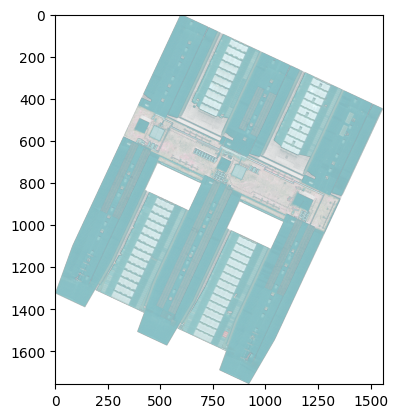

In [64]:
# show example
fig = plt.figure()
example_sample = plt.imread("../results/images/tiles_dark/samp_11524802.tif")
plt.imshow(example_sample)
plt.show()
fig.savefig("../results/preprocess/cropped.png")
plt.close()

### NDVI Generation

In [9]:
def ndvi_samp_gen(arr_input):
    R = arr_input[0,:,:].astype(float)
    NIR = arr_input[3,:,:].astype(float)
    ndvi = np.divide(NIR - R, NIR + R, out=np.zeros(R.shape, dtype=float), where= NIR + R != 0)
    ndvi = ndvi.reshape((1,ndvi.shape[0], ndvi.shape[1]))
    return ndvi

def ndvi_val_to_8bits(ndvi):
    return ((ndvi + 1)/2 * 256).astype(int)

In [14]:
# tests
test_samp_name = "samp_295071436_ndvi.tif"
src_samp_name = "samp_295071436.tif"
test_samp_src = "../results/images/tiles_ndvi/" + test_samp_name
src_samp = "../results/images/tiles/" + src_samp_name

img_arr = rasterio.open(src_samp).read()
ndvi_arr = ndvi_samp_gen(img_arr)

test_arr = rasterio.open(test_samp_src).read()
print(test_arr.shape)
print(f"min, max : {np.min(test_arr)}, {np.max(test_arr)}")
print(ndvi_arr.shape)
print(f"min, max : {np.min(ndvi_arr)}, {np.max(ndvi_arr)}")

(1, 485, 431)
min, max : -0.817258883248731, 0.6181818181818182
(1, 485, 431)
min, max : -0.817258883248731, 0.6181818181818182


In [13]:
# data sources
input_dir = "../results/images/tiles"
output_dir = "../results/images/tiles_ndvi"

for r, d, f in os.walk(input_dir):
    for _, file in tqdm(enumerate(f,), total=len(f)):
        if file.endswith('.tif'):
            file_name = file[:-4]
            file_src = r + '/' + file
            file_src = file_src.replace('\\','/')
            img = rasterio.open(file_src)
            img_arr = img.read()
            ndvi_canal = ndvi_samp_gen(img_arr)
            ndvi_img = ndvi_val_to_8bits(ndvi_canal)
            # write ndvi image
            out_meta = img.meta
            out_meta.update({
                "driver": "GTiff",
                "count": 1,
                "dtype": ndvi_canal.dtype,
            })
            with rasterio.open(output_dir + '/' + file_name + "_ndvi.tif", "w", **out_meta) as dst:
                dst.write(ndvi_canal)
            with rasterio.open("../results/images/tiles_ndvi_8bits/" + file_name + "_ndvi_8bits.tif", "w", **out_meta) as dst:
                dst.write(ndvi_img)
            
            

100%|██████████| 3785/3785 [01:48<00:00, 34.74it/s]


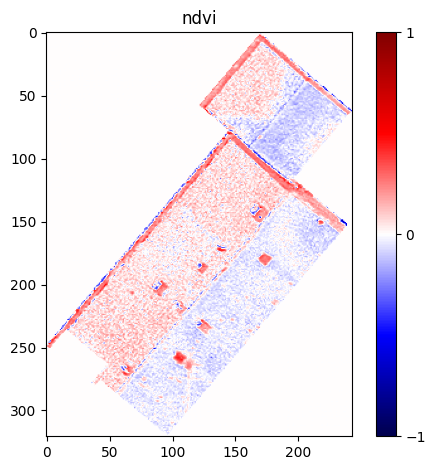

AttributeError: 'Figure' object has no attribute 'close'

In [66]:
# show example
img = rasterio.open("../results/images/tiles_ndvi/samp_1005667_ndvi.tif").read()
fig = plt.figure()
plt.imshow(img[0,...], cmap='seismic', vmin=-1, vmax = 1)
colorbar = plt.colorbar(fraction=0.06, pad=0.04)
colorbar.set_ticks([-1, 0, 1])
plt.title("ndvi")
plt.show()
fig.savefig("../results/preprocess/ndvi.png")
plt.close()

### Greenery masking

In [52]:
def ndvi_to_mask(ndvi, threshold=0.0):
    return (ndvi < threshold).reshape((ndvi.shape[1],ndvi.shape[2]))

def mask_nbh_rounding(mask, nbh=1, add=0):
    assert(nbh>=1)
    assert(len(mask.shape) == 2)
    mask = mask.astype(int)
    new_mask = np.copy(mask)
    width = mask.shape[1]
    height = mask.shape[0]
    for i in range(height):
        for j in range(width):
            if mask[i,j] == 1:
                count = np.sum(mask[np.clip(i-nbh,a_min=0, a_max=None):np.clip(i+nbh + 1,a_max=height, a_min=None),
                                    np.clip(j-nbh,a_min=0, a_max=None):np.clip(j+nbh + 1, a_max=width, a_min=None),
                                    ])
                if count <= 2**(nbh+1) + add:
                    new_mask[i,j] = 0
    return new_mask.astype(bool)

In [32]:
# test1
print("test masking")
arr = np.arange(12).reshape((1,3,4)) - 6
print(arr)
print(ndvi_to_mask(arr))

# test 2
print("test rounding of mask")
arr = np.zeros((20,20)).astype(int)
arr[5:15:2,5:15:2] = 1
arr[7,8] = 1
arr[8,7] = 1
arr[2,2] = 1

arr_round = mask_nbh_rounding(arr)
print(arr)
print("---------")
print(arr_round.astype(int))
print("---------")
print(arr_round.astype(int) - arr)

# test 3
print("test applyng mask to image")
a = np.arange(6).reshape((2,3))
mask = np.zeros((2,3))
mask[::2,::2] = 1
mask = mask.astype(bool)
print(mask)
a[mask] = 0
print(a)
print(a.dtype)

test masking
[[[-6 -5 -4 -3]
  [-2 -1  0  1]
  [ 2  3  4  5]]]
[[False False False False]
 [False False False  True]
 [ True  True  True  True]]
test rounding of mask
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 

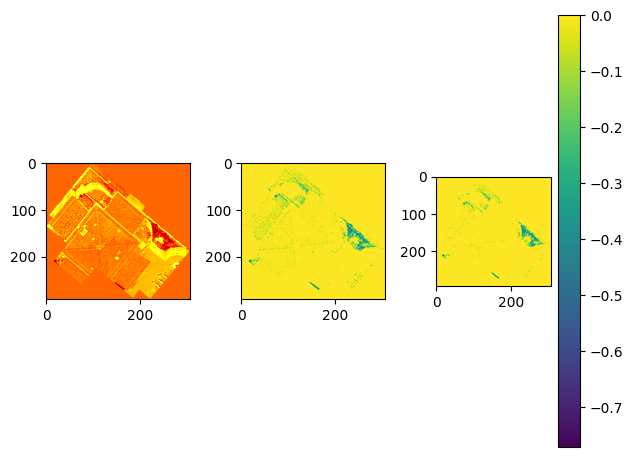

In [46]:
# real test
samp_src = "../results/images/tiles_ndvi/samp_1005664_ndvi.tif"
arr = rasterio.open(samp_src).read()
mask = ndvi_to_mask(arr)
mask_smooth = mask_nbh_rounding(mask)
arr_masked = np.copy(arr)
arr_masked_smooth = np.copy(arr)
for i in range(arr.shape[0]):
    arr_masked[i,mask] = 0
    arr_masked_smooth[i,mask_smooth] = 0

#show results
fig,axs = plt.subplots(1,3)
axs[0].imshow(arr[0,...], cmap='hot')
axs[1].imshow(arr_masked[0,...])
plot3 = axs[2].imshow(arr_masked_smooth[0,...])
plt.colorbar(plot3, ax=axs[2])
plt.tight_layout()
plt.show()



In [54]:
# data sources
input_img = "../results/images/tiles_dark"
input_ndvi = "../results/images/tiles_ndvi"
output_dir = "../results/images/tiles_masked"

# generation and application of mask and smooth mask on ndvi layer
for r, d, f in os.walk(input_img):
    for _, file in tqdm(enumerate(f,), total=len(f)):
        # get original image
        file_name = file[:-4]
        file_src = r + '/' + file
        file_src = file_src.replace('\\','/')
        img = rasterio.open(file_src)
        img_arr = img.read()

        # get ndvi
        ndvi_src = input_ndvi + '/' + file_name + '_ndvi.tif'
        ndvi_arr = rasterio.open(ndvi_src).read()
        
        # compute masks
        mask = ndvi_to_mask(ndvi_arr)
        mask_smooth = mask_nbh_rounding(mask)

        # apply masks on each band
        img_masked = np.copy(img_arr)
        img_masked_smooth = np.copy(img_arr)
        for i in range(img_arr.shape[0]):
            img_masked[i,mask] = 0
            img_masked_smooth[i,mask_smooth] = 0

        # save masked rasters
        with rasterio.open(output_dir + '/' + file_name + "_masked.tif", "w", **img.meta) as dst:
            dst.write(img_masked)
        with rasterio.open(output_dir + '/' + file_name + "_masked_smooth.tif", "w", **img.meta) as dst:
            dst.write(img_masked_smooth)

            


100%|██████████| 3784/3784 [08:04<00:00,  7.82it/s]


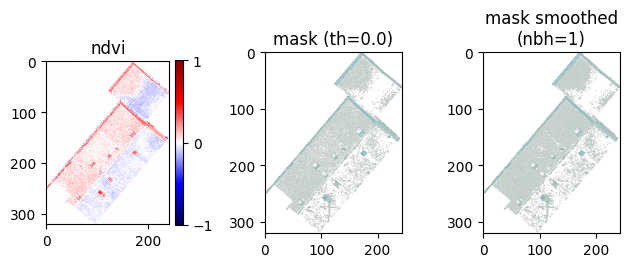

In [38]:
#show example
sample_name = "samp_1005667"
fig,axs = plt.subplots(1,3)
img_ndvi = rasterio.open("../results/images/tiles_ndvi/" + sample_name + "_ndvi.tif").read()[0,...]
ndvi_plot = axs[0].imshow(img_ndvi, cmap='seismic', vmin=-1, vmax = 1)
img_masked = plt.imread("../results/images/tiles_masked/" + sample_name + "_masked.tif")
axs[1].imshow(img_masked, cmap='hot')
img_masked_smooth = plt.imread("../results/images/tiles_masked/" + sample_name + "_masked_smooth.tif")
axs[2].imshow(img_masked_smooth, cmap='hot')
colorbar = plt.colorbar(ndvi_plot, ax = axs[0],fraction=0.06, pad=0.04)
colorbar.set_ticks([-1,0,1])
axs[0].set_title("ndvi")
axs[1].set_title("mask (th=0.0)")
axs[2].set_title("mask smoothed\n(nbh=1)")
plt.tight_layout()
plt.show()
fig.savefig("../results/preprocess/mask.png")
plt.close()

### Split among classes

In [90]:
# data sources
input_dir = "../results/images/tiles"
output_dir = "../results/images/tiles_categories"
roofs_dir = "../data/gt_tot.gpkg"

categories = {
    'b' : 'bare',
    'e' : 'extensive',
    'i' : 'intensive',
    'l' : 'lawn',
    's' : 'spontaneous',
    't' : 'terraces',
}

# create architecture if necessary
directories = {}
directories['.'] = output_dir
for let, cat in categories.items():
    directories[let] = output_dir + "/" + cat

for dir in directories.values():
    if not os.path.exists(dir):
        os.mkdir(dir)

# go throught polygons and move samples to correct directory

# open geopackage file
roofs = gpd.read_file(roofs_dir).to_crs(2056)

# loop on each roof
for roof in tqdm(roofs.itertuples(), total=len(roofs)):
    egid = int(roof.EGID)
    cat = roof[5]

    # get corresponding sample
    sample_name = "samp_" + str(egid) + ".tif"
    sample_src = input_dir + '/' + sample_name
    if not os.path.exists(sample_src):
        raise NameError(f"no file with egid {egid} in the source!")
    
    # place it to corresponding folder
    if cat in directories.keys():
        target_src = directories[cat] + '/' + sample_name
        shutil.copyfile(sample_src,target_src)
    else:
        raise ValueError(f"no category with letter '{cat}' !")

100%|██████████| 3784/3784 [00:01<00:00, 2183.03it/s]


### Normalize image size

(5, 56, 62)


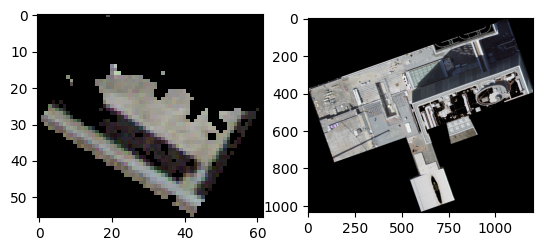

In [13]:
# data sources
sample_big_src = "../data/test/dataset/bare/samp_146960.tif"
sample_small_src = "../data/test/dataset/bare/samp_295071012.tif"

# show original samples
img_small = rasterio.open(sample_small_src).read()
img_big = rasterio.open(sample_big_src).read()
print(img_small.shape)
fig, axs = plt.subplots(1,2)
axs[0].imshow(np.permute_dims(img_small[1:4,...], [1,2,0]))
axs[1].imshow(np.permute_dims(img_big[1:4,...], [1,2,0]))
axs[0].set_title("Small image")
axs[1].set_title("Big image")
plt.show()

(5, 56, 62)
(5, 128, 128)


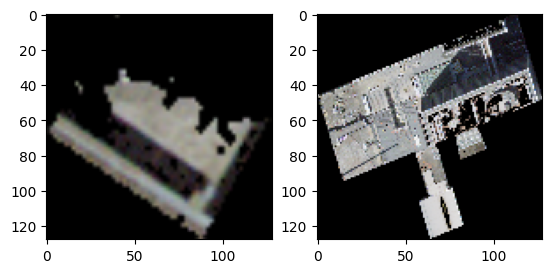

In [28]:
# convert samples to new size
print(img_small.shape)
img_small_resized = resize(img_small, [5, 128, 128], anti_aliasing=False)
img_big_resized = resize(img_big, [5, 128, 128], anti_aliasing=False)
print(img_small_resized.shape)

fig, axs = plt.subplots(1,2)
axs[0].imshow(np.permute_dims(img_small_resized[1:4,...],[1,2,0]))
axs[1].imshow(np.permute_dims(img_big_resized[1:4,...],[1,2,0]))

plt.show()

### Tests on final sample

In [4]:
# loading a sample
sample_tif_src = "../data/test/dataset/bare/samp_146960.tif"
sample_pkl_src = "../data/test/dataset/bare/samp_146960.pickle"
img_tif_src = rasterio.open(sample_tif_src).read()

with open(sample_pkl_src, 'rb') as pkl:
    img_pkl_src = pickle.load(pkl)

# print basic stats per band
for i in range(img_tif_src.shape[0]):
    print(f"Type: {img_tif_src.dtype}")
    print("BAND " + str(i))
    print(f"\t- tif min : {np.min(img_tif_src[i,...])}")
    print(f"\t- tif max : {np.max(img_tif_src[i,...])}")
    print(f"\t- pkl min : {np.min(img_pkl_src[i,...])}")
    print(f"\t- pkl max : {np.max(img_pkl_src[i,...])}")




Type: uint16
BAND 0
	- tif min : 0
	- tif max : 9305
	- pkl min : 0.0
	- pkl max : 9305.50341796875
Type: uint16
BAND 1
	- tif min : 0
	- tif max : 13078
	- pkl min : 0.0
	- pkl max : 13078.196517944336
Type: uint16
BAND 2
	- tif min : 0
	- tif max : 14043
	- pkl min : 0.0
	- pkl max : 14043.177017211914
Type: uint16
BAND 3
	- tif min : 0
	- tif max : 13820
	- pkl min : 0.0
	- pkl max : 13820.428100585938
Type: uint16
BAND 4
	- tif min : 0
	- tif max : 0
	- pkl min : -0.5251887683084036
	- pkl max : 0.6210464466288146
Type: uint16
BAND 5
	- tif min : 0
	- tif max : 36426
	- pkl min : 0.0
	- pkl max : 36426.876953125


### 16bits samples range limiting

POLYGON ((2503804.094300002 1116565.0984999985, 2503802.8147 1116563.5874999985, 2503802.5546999983 1116563.8275999986, 2503805.0139000006 1116566.7890000008, 2503817.0209 1116580.8960999995, 2503814.670600001 1116582.8959, 2503819.529199999 1116588.6187000014, 2503826.770199999 1116582.4692000002, 2503822.1713999994 1116577.0566999987, 2503826.4519999996 1116573.4169000015, 2503820.4025 1116566.3326000012, 2503812.1154999994 1116556.6272, 2503806.7950999998 1116561.0980999991, 2503806.3552 1116560.5877999999, 2503806.085099999 1116560.8077999987, 2503807.3849 1116562.308699999, 2503804.094300002 1116565.0984999985))
2


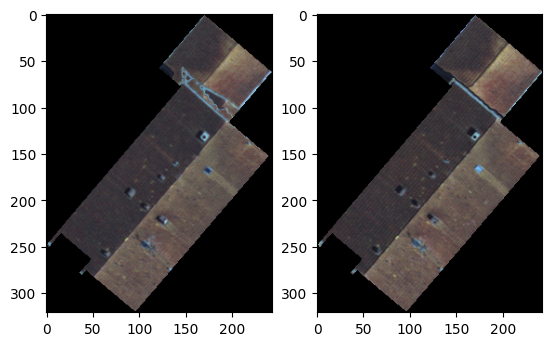

In [2]:
# getting sample:
sample_egid = 1005667
roofs = gpd.read_file("../data/sources/gt_tot.gpkg")
geom = roofs.loc[roofs.EGID == sample_egid, 'geometry'].values[0]
print(geom)

# get rasters
raster_list = []

for r, d, f in os.walk("../data/sources/tlm_dataset"):
    for file in f:
        if file.endswith('.tif'):
            file_src = r + '/' + file
            file_src = file_src.replace('\\','/')
            raster_list.append(rasterio.open(file_src))
matching_rasters = []

for raster in raster_list:
    # catch the error when polygon doesn't match raster and just continue to next raster
    try:
        out_image, out_transform = mask(raster, [geom], crop=True)
        out_image_for_show = ((out_image-np.min(out_image))/(np.max(out_image)-np.min(out_image))*255).astype(int)
        sample_formats = out_image.dtype
    except ValueError:
        continue
    else:
        matching_rasters.append(out_image_for_show)

print(len(matching_rasters))

fig, axs = plt.subplots(1,2)
axs[0].imshow(np.moveaxis(matching_rasters[0], 0, 2)[...,0:3])
axs[1].imshow(np.moveaxis(matching_rasters[1], 0, 2)[...,0:3])
plt.show()
plt.close()

sample = out_image

In [4]:
THRESHOLD = 1000

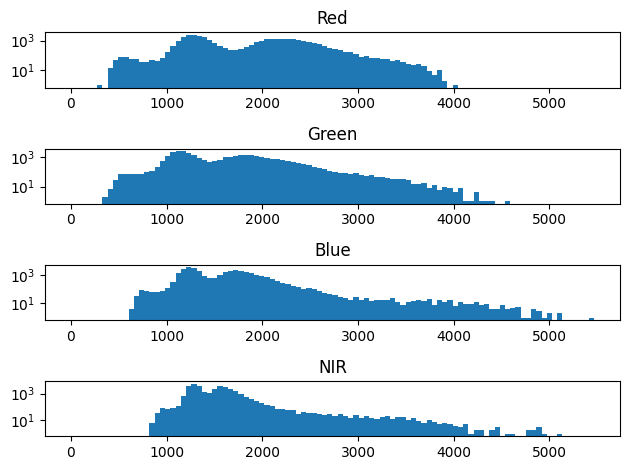

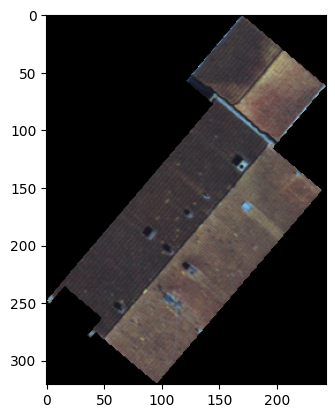

In [4]:
# show histo of values:
bands = ['Red', 'Green', 'Blue', 'NIR']
fig, axs = plt.subplots(4,1)
for i in range(4):
    #axs[i].hist(sample[i, ...], log=False, range=[0, np.max(sample)])
    axs[i].hist(sample[i, ...].flatten(), bins=100, log=True, range=[1,np.max(sample)])
    #axs[i].hist(sample[i, ...].flatten(), bins=100, log=True)
    axs[i].set_title(bands[i])
plt.tight_layout()
plt.show()
plt.close()

out_image_for_show = ((sample-np.min(sample))/(np.max(sample)-np.min(sample))*255).astype(int)
fig = plt.figure()
plt.imshow(np.moveaxis(out_image_for_show, 0, 2)[...,0:3])
plt.show()
plt.close()

In [5]:
THRESHOLD = 1000

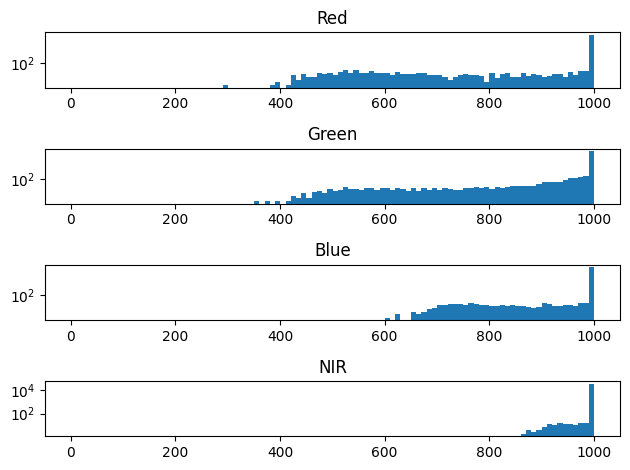

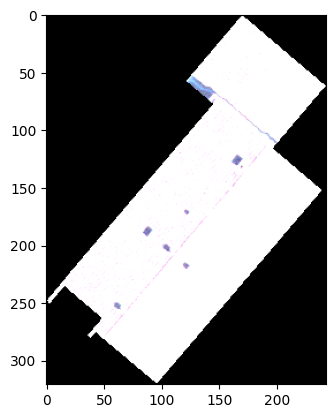

In [6]:
# Clipping to THRESHOLD:
#sample_cropped  = np.clip(sample, a_min=0, a_max=THRESHOLD)
sample_cropped = range_limiting(sample,THRESHOLD,'clip')
# show histo of values:
bands = ['Red', 'Green', 'Blue', 'NIR']
fig, axs = plt.subplots(4,1)
for i in range(4):
    axs[i].hist(sample_cropped[i, ...].flatten(), bins=100, log=True, range=[1,THRESHOLD])
    axs[i].set_title(bands[i])
plt.tight_layout()
plt.show()
plt.close()

out_image_for_show = (sample_cropped / THRESHOLD * 255).astype(int)
fig = plt.figure()
plt.imshow(np.moveaxis(out_image_for_show, 0, 2)[...,0:3])
plt.show()
plt.close()

In [15]:
print(np.sum(sample_cropped[sample_cropped == 1000]))
print(sample_cropped.shape)
import platform
print(platform.system())

128729000
(4, 321, 243)
Windows


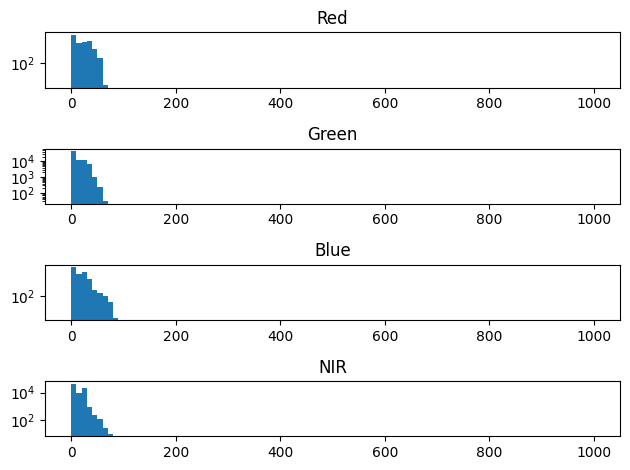

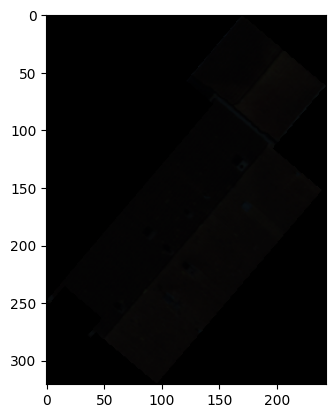

In [8]:
# normalize to THRESHOLD:
val_max = 2**16-1
#sample_norm = sample / val_max * THRESHOLD
sample_norm = range_limiting(sample,THRESHOLD,'norm')

# show histo of values:
bands = ['Red', 'Green', 'Blue', 'NIR']
fig, axs = plt.subplots(4,1)
for i in range(4):
    axs[i].hist(sample_norm[i, ...].flatten(), bins=100, log=True, range=[0, THRESHOLD])
    axs[i].set_title(bands[i])
plt.tight_layout()
plt.show()
plt.close()

out_image_for_show = (sample_norm / THRESHOLD * 255).astype(int)
fig = plt.figure()
plt.imshow(np.moveaxis(out_image_for_show, 0, 2)[...,0:3])
plt.show()
plt.close()

Val log max : 0.8779965504844773
Min : 0.0
Max : 776.0014068966939
----------


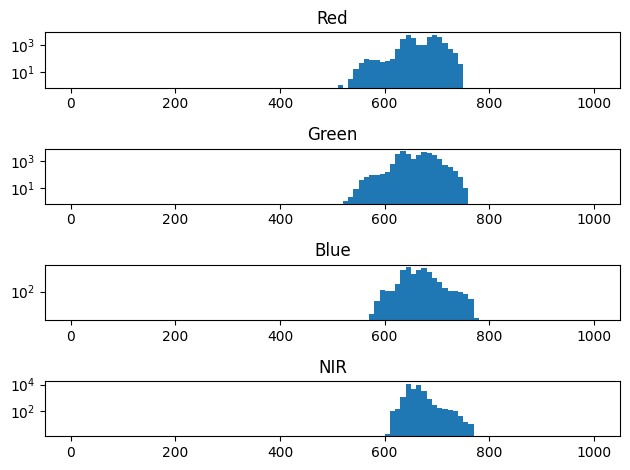

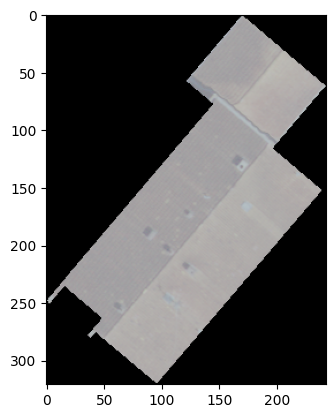

In [9]:
# log-normalize to THRESHOLD:
val_max = 2**16-1

val_log_max = np.log(np.log(-np.log(1/val_max)))
print(f"Val log max : {val_log_max}")

val_log_max = np.log(val_max)
#sample_log_norm = np.log(sample, where=(sample!=0)) / val_log_max * THRESHOLD
sample_log_norm = range_limiting(sample,THRESHOLD,'log_norm')

print(f"Min : {np.min(sample_log_norm)}")
print(f"Max : {np.max(sample_log_norm)}")
print("-"*10)

# show histo of values:
bands = ['Red', 'Green', 'Blue', 'NIR']
fig, axs = plt.subplots(4,1)
for i in range(4):
    axs[i].hist(sample_log_norm[i, ...].flatten(), bins=100, log=True, range=[1, THRESHOLD])
    axs[i].set_title(bands[i])
plt.tight_layout()
plt.show()
plt.close()

out_image_for_show = (sample_log_norm / THRESHOLD * 255).astype(int)
fig = plt.figure()
plt.imshow(np.moveaxis(out_image_for_show, 0, 2)[...,0:3])
plt.show()
plt.close()

Val log max : 0.8779965504844773
Min : 0.0
Max : 776.0014068966939
Min : 0.0
Max : 920.0046896556463
----------


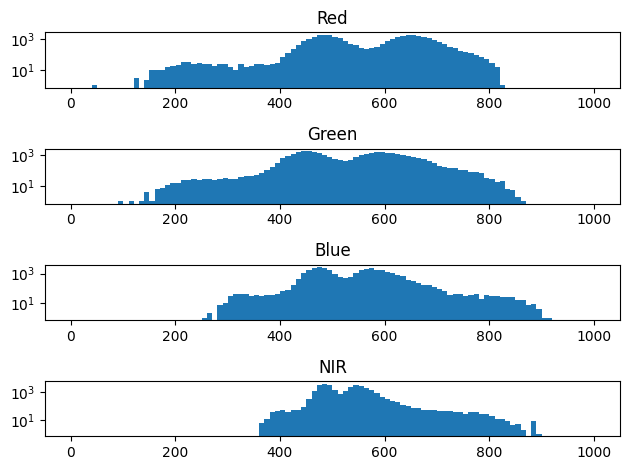

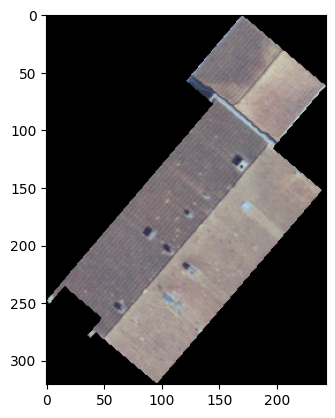

In [10]:
# log-normalize to THRESHOLD:
val_max = 2**16-1

val_log_max = np.log(np.log(-np.log(1/val_max)))
print(f"Val log max : {val_log_max}")

val_log_max = np.log(val_max)
sample_log_norm = np.log(sample, where=(sample!=0)) / val_log_max * THRESHOLD

minval = 500
maxval = 800
print(f"Min : {np.min(sample_log_norm)}")
print(f"Max : {np.max(sample_log_norm)}")
sample_log_norm = (sample_log_norm-minval)/(maxval - minval) * 1000
sample_log_norm = np.clip(sample_log_norm, 0, 1000)
print(f"Min : {np.min(sample_log_norm)}")
print(f"Max : {np.max(sample_log_norm)}")
print("-"*10)

# show histo of values:
bands = ['Red', 'Green', 'Blue', 'NIR']
fig, axs = plt.subplots(4,1)
for i in range(4):
    axs[i].hist(sample_log_norm[i, ...].flatten(), bins=100, log=True, range=[1, THRESHOLD])
    axs[i].set_title(bands[i])
plt.tight_layout()
plt.show()
plt.close()

out_image_for_show = (sample_log_norm / THRESHOLD * 255).astype(int)
fig = plt.figure()
plt.imshow(np.moveaxis(out_image_for_show, 0, 2)[...,0:3])
plt.show()
plt.close()

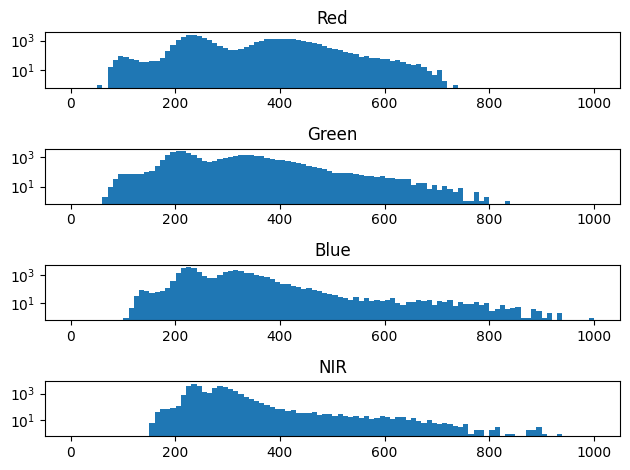

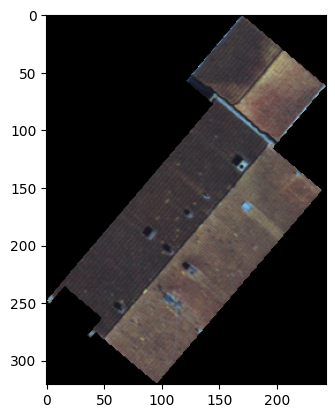

In [11]:
THRESHOLD=1000
# normalize to THRESHOLD:
val_max = 2**16-1
#sample_norm = sample / np.max(sample) * THRESHOLD
sample_norm = range_limiting(sample,THRESHOLD,'self_max_norm')

# show histo of values:
bands = ['Red', 'Green', 'Blue', 'NIR']
fig, axs = plt.subplots(4,1)
for i in range(4):
    axs[i].hist(sample_norm[i, ...].flatten(), bins=100, log=True, range=[1, THRESHOLD])
    axs[i].set_title(bands[i])
plt.tight_layout()
plt.show()
plt.close()

out_image_for_show = (sample_norm / THRESHOLD * 255).astype(int)
fig = plt.figure()
plt.imshow(np.moveaxis(out_image_for_show, 0, 2)[...,0:3])
plt.show()
plt.close()

### Overlapping samples

295071369
shape of image 0 : (4, 73, 5)
 total pixels in image 0: 139
shape of image 1 : (4, 73, 5)
 total pixels in image 1: 82
shape of image 2 : (4, 73, 5)
 total pixels in image 2: 134


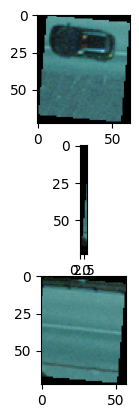

In [13]:
raster_src = "../data/sources/scratch_dataset"
polygon_src = "../data/sources/gt_tot.gpkg"

# get rasters
raster_list = []

for r, d, f in os.walk(raster_src):
    for file in f:
        if file.endswith('.tif'):
            file_src = r + '/' + file
            file_src = file_src.replace('\\','/')
            raster_list.append(rasterio.open(file_src))

# get polygons of roofs
roofs = gpd.read_file(polygon_src).to_crs(2056)

for roof in roofs.itertuples(index=True):
    geom = roof.geometry
    cat = roof[5]
    egid = str(int(roof.EGID))

    # loop over the rasters to find the one matching
    matching_rasters = []
    matching_img = []
    sample_formats = ""
    for raster in raster_list:
        # catch the error when polygon doesn't match raster and just continue to next raster
        try:
            out_image, out_transform = mask(raster, [geom], crop=True)
            sample_formats = out_image.dtype
        except ValueError:
            continue
        else:
            matching_rasters.append(raster)
            matching_img.append(out_image)

    # test if polygon match with one and only one raster:
    if len(matching_rasters) > 2:
        print(egid)
        fig, axs = plt.subplots(len(matching_rasters), 1)
        for i in range(len(matching_rasters)):
            print(f"shape of image {i} : {matching_img[1].shape}")
            print(f" total pixels in image {i}: {np.sum(matching_img[i].shape)}")
            axs[i].imshow(np.moveaxis(matching_img[i][0:3,...],0,2))
        plt.show()
        plt.close()
        break

### WhiteboxTools testing

In [3]:
from whitebox import WhiteboxTools
wbt = WhiteboxTools()

In [50]:

src_raster = "D:/GitHubProjects/STDL_Classifier/data/sources/scratch_dataset/2023/GE/scratch_20230527_0941_12501_0_13.tif"
src_polygon = "D:/GitHubProjects/STDL_Classifier/data/sources/gt_tot.gpkg"
src_polygon_temp = "D:/GitHubProjects/STDL_Classifier/test/temp_polygon.shp"
src_target = 'D:/GitHubProjects/STDL_Classifier/test/test_tif_mask.tif'
roofs = gpd.read_file(src_polygon)

egid = 295139792
geom = list(roofs.loc[roofs.EGID.astype(int) == egid].geometry.values)[0]
print(geom)
gpd.GeoDataFrame(index = [0], crs="EPSG:2056", geometry= [geom]).to_file(src_polygon_temp)
# geom.to_file(src_polygon_temp)




POLYGON ((2500321.1055000015 1116420.820799999, 2500321.0206730664 1116420.6951508657, 2500320.925396821 1116420.5772282188, 2500320.820371377 1116420.4678985807, 2500320.706368486 1116420.367965331, 2500320.5842258665 1116420.2781628019, 2500320.4548410517 1116420.1991508834, 2500320.31916479 1116420.131510173, 2500320.178194063 1116420.07573771, 2500320.032964755 1116420.0322433237, 2500319.884544044 1116420.0013466207, 2500319.7340225605 1116419.9832746373, 2500319.5825063703 1116419.97816017, 2500319.4311088496 1116419.9860408015, 2500319.2809425024 1116420.006858623, 2500319.133110785 1116420.0404606604, 2500318.9886999987 1116420.0865999982, 2500318.8461942975 1116420.1465190009, 2500318.7094607954 1116420.2186446635, 2500318.5795426425 1116420.302426734, 2500318.4574309937 1116420.3972260326, 2500318.3440574477 1116420.5023193287, 2500318.24028694 1116420.6169048578, 2500318.1469111424 1116420.7401084385, 2500318.064642427 1116420.8709901418, 2500317.994108427 1116421.0085514614

In [43]:
raster = rasterio.open(src_raster).read()
print(raster.shape)

(4, 12300, 11264)


In [52]:

wbt.clip_raster_to_polygon(src_raster, src_polygon_temp, src_target)

.\whitebox_tools.exe --run="ClipRasterToPolygon" --input='D:/GitHubProjects/STDL_Classifier/data/sources/scratch_dataset/2023/GE/scratch_20230527_0941_12501_0_13.tif' --polygons='D:/GitHubProjects/STDL_Classifier/test/temp_polygon.shp' --output='D:/GitHubProjects/STDL_Classifier/test/test_tif_mask.tif' -v --compress_rasters=False

**********************************
* Welcome to ClipRasterToPolygon *
* Powered by WhiteboxTools       *
* www.whiteboxgeo.com            *
**********************************
Reading data...
Progress (rec 1 of 1 part 1): 0%
Progress (rec 1 of 1 part 1): 1%
Progress (rec 1 of 1 part 1): 2%
Progress (rec 1 of 1 part 1): 3%
Progress (rec 1 of 1 part 1): 4%
Progress (rec 1 of 1 part 1): 5%
Progress (rec 1 of 1 part 1): 6%
Progress (rec 1 of 1 part 1): 7%
Progress (rec 1 of 1 part 1): 8%
Progress (rec 1 of 1 part 1): 9%
Progress (rec 1 of 1 part 1): 10%
Progress (rec 1 of 1 part 1): 11%
Progress (rec 1 of 1 part 1): 12%
Progress (rec 1 of 1 part 1): 13%
Progress (

0

In [46]:
wbt = WhiteboxTools()
wbt.set_whitebox_dir("../.venv/Lib/site-packages/whitebox")  # Set this if WhiteboxTools is in a specific directory
print(wbt.version()) 
import os
print(os.path.exists(src_raster))  # Should return True if the file exists
print(os.path.exists(src_polygon_temp))  # Should return True if the file exists

WhiteboxTools v2.4.0 (c) Dr. John Lindsay 2017-2023

WhiteboxTools is an advanced geospatial data analysis platform developed at
the University of Guelph's Geomorphometry and Hydrogeomatics Research 
Group (GHRG). See www.whiteboxgeo.com for more details.

True
True


### Repartition of samples when filtering the smallest ones out

In [7]:
def src_to_intlist(src):
    with open(src, 'r') as file:
        lst_egids = file.read()
    lst_egids = lst_egids.replace('[', '')
    lst_egids = lst_egids.replace(']', '')
    lst_egids = lst_egids.replace(' ', '')
    lst_egids = [int(x) for x in lst_egids.split(',')]
    return lst_egids

src_egids_500 = "../data/test/test_sample_size_threshold/too_small_roofs_th=500.txt"
src_egids_1000 = "../data/test/test_sample_size_threshold/too_small_roofs_th=1000.txt"
src_egids_1500 = "../data/test/test_sample_size_threshold/too_small_roofs_th=1500.txt"
src_egids_2000 = "../data/test/test_sample_size_threshold/too_small_roofs_th=2000.txt"
src_egids_3000 = "../data/test/test_sample_size_threshold/too_small_roofs_th=3000.txt"
src_egids_4000 = "../data/test/test_sample_size_threshold/too_small_roofs_th=4000.txt"
src_egids_5000 = "../data/test/test_sample_size_threshold/too_small_roofs_th=5000.txt"
dict_egids = {
    '500': src_to_intlist(src_egids_500),
    '1000': src_to_intlist(src_egids_1000),
    '1500': src_to_intlist(src_egids_1500),
    '2000': src_to_intlist(src_egids_2000),
    '3000': src_to_intlist(src_egids_3000),
    '4000': src_to_intlist(src_egids_4000),
    '5000': src_to_intlist(src_egids_5000),
}
for x,y in dict_egids.items():
    print(f"th {x} - {len(y)} samples")


th 500 - 21 samples
th 1000 - 42 samples
th 1500 - 83 samples
th 2000 - 112 samples
th 3000 - 171 samples
th 4000 - 228 samples
th 5000 - 310 samples


In [13]:
dict_num_to_cat = {0:'b', 1:'t', 2:'s', 3:'e', 4:'l', 5:'i'}
dict_cat_to_num = {y:x for x,y in dict_num_to_cat.items()}
dict_cat_to_label={'b':'bare', 't':'terrace', 's':'spontaneous', 'e':'extensive', 'l':'lawn', 'i':'intensive'}
roofs = gpd.read_file("../data/sources/gt_tot.gpkg")
dict_cats = {key:np.zeros(6) for key in dict_egids.keys()}
for th,egids in dict_egids.items():
    for egid in egids:
        cat = roofs.loc[roofs.EGID == egid,'class'].values[0]
        dict_cats[th][dict_cat_to_num[cat]] += 1

print("REPARTITION IN CLASSES: bare, terrace, spontaneous, extensive, lawn, intensive\n")
for x,y in dict_cats.items():
    print(f"th {x} - {y}")


REPARTITION IN CLASSES: bare, terrace, spontaneous, extensive, lawn, intensive

th 500 - [20.  0.  0.  0.  0.  1.]
th 1000 - [41.  0.  0.  0.  0.  1.]
th 1500 - [79.  0.  2.  0.  1.  1.]
th 2000 - [103.   0.   4.   0.   1.   4.]
th 3000 - [156.   1.   7.   2.   1.   4.]
th 4000 - [206.   2.   9.   5.   2.   4.]
th 5000 - [279.   2.  13.   8.   3.   5.]
